In [38]:
%matplotlib inline
import os
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException
from ClientCredentials import client_id, client_secret

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier

# pandas settings
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
def get_playlist_tracks(playlist):
    track_ids = []
    track_names = []
    
    for i in range(0, playlist['tracks']['total'], 100):
        track_results = spotify.user_playlist_tracks(playlist['owner']['id'], playlist['id'], offset=i, limit=100)
        for track in track_results['items']:
            track_ids.append(track['track']['id'])
            track_names.append(track['track']['name'])
    
    return track_ids, track_names

In [3]:
def get_features(track_ids):
    features = []

    for track_id in track_ids:
        feats = spotify.audio_features(track_id)
        for track in feats:
            features.append(track)
    return features

In [4]:
username_id = '113586775'

playlist_of_interest_name = 'Favorites'

In [5]:
# Logging in
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
# Which playlists do I have?
playlists = spotify.user_playlists(username_id)

playlists_of_no_interest = []
for playlist in playlists['items']:
    if playlist['name'] == playlist_of_interest_name:
        playlist_of_interest = playlist
    elif playlist['owner']['id'] == username_id:
        playlists_of_no_interest.append(playlist)

try:
    playlist_of_interest
except NameError:
    print("Given playlist name is not defined")


In [7]:
good_track_ids, good_track_names = get_playlist_tracks(playlist_of_interest)

bad_track_ids = []
bad_track_names = []

for playlist in playlists_of_no_interest:
    tmp_ids, tmp_names = get_playlist_tracks(playlist)
    
    for tmp_id, tmp_name in zip(tmp_ids, tmp_names):
        if tmp_id not in good_track_ids and tmp_id not in bad_track_ids:
            bad_track_ids.append(tmp_id)
            bad_track_names.append(tmp_name)

In [8]:
ratings = [1] * len(good_track_ids) + [0] * len(bad_track_ids)
track_ids = good_track_ids + bad_track_ids
track_names = good_track_names + bad_track_names

In [9]:
if not os.path.isfile('track_features.csv'):
    print("Audio features not found")
    print("\tCalculating ...")
    features = get_features(track_ids)
    favorites_df = pd.DataFrame(features, index=track_names)
    favorites_df['rating'] = ratings
    favorites_df.to_csv('track_features.csv')
else:
    print("Audio features found")
    read_df = pd.read_csv('track_features.csv', index_col=0)
    read_ids = read_df['id']
    
    print("\tFinding new tracks ...")
    tmp_indices = []
    for i, track_id in enumerate(track_ids):
        if track_id not in read_ids.values:
            tmp_indices.append(i)

    tmp_ids = [track_ids[i] for i in tmp_indices]
    tmp_names = [track_names[i] for i in tmp_indices]
    tmp_ratings = [ratings[i] for i in tmp_indices]
    tmp_features_df = pd.DataFrame(get_features(tmp_ids), index=tmp_names)
    tmp_features_df['rating'] = tmp_ratings
    
    print("\tUpdating audio features ...")
    tmp_features_df.to_csv('track_features.csv', mode='a')
    
    print("\tCreating audio features dataframe ...")
    read_df = pd.concat([read_df, tmp_features_df])
    favorites_df = read_df[read_df['id'].isin(track_ids)]

print("Done!")
favorites_df

Audio features found
	Finding new tracks ...
	Updating audio features ...
	Creating audio features dataframe ...
Done!


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,rating
Citizen/Soldier,0.631,0.822,8.0,-5.503,1.0,0.0343,0.01140,0.017000,0.1970,0.4830,96.999,audio_features,3NZr9rsioE182Rv8dqZG6g,spotify:track:3NZr9rsioE18...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,232907.0,4.0,1.0
Waterline - 2010 - Remaster,0.386,0.797,0.0,-7.230,1.0,0.0372,0.00189,0.000005,0.0959,0.2300,108.836,audio_features,0ayPGGN1YW9lU7v00uOM5E,spotify:track:0ayPGGN1YW9l...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,273160.0,4.0,1.0
Love Is a Loser's Game - 2010 - Remaster,0.307,0.555,10.0,-7.354,0.0,0.0255,0.01410,0.000000,0.0865,0.2650,90.640,audio_features,7oyVUb08xXoOqlvtoI1c8Y,spotify:track:7oyVUb08xXoO...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,227933.0,4.0,1.0
Sweet Child O' Mine,0.435,0.947,6.0,-4.759,1.0,0.0489,0.08760,0.072700,0.1130,0.6370,125.133,audio_features,32e5Wq10DT7xYrlRl5qSYF,spotify:track:32e5Wq10DT7x...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,355267.0,4.0,1.0
Paradise City,0.277,0.979,11.0,-5.578,1.0,0.0979,0.01830,0.013800,0.1170,0.4510,100.339,audio_features,2bHQrsgmBzX5WF7thpMZrV,spotify:track:2bHQrsgmBzX5...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,406200.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.172,0.228,2.0,-17.281,0.0,0.0397,0.62200,0.945000,0.0705,0.0339,129.148,audio_features,2V3hP9u4jI9I9ftHrgZ0MF,spotify:track:2V3hP9u4jI9I...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,320467.0,3.0,0.0
Brass Buttons,0.161,0.345,9.0,-16.228,0.0,0.0435,0.13100,0.853000,0.1890,0.0603,94.033,audio_features,5kHSrLEGsoOTfazEKvVliP,spotify:track:5kHSrLEGsoOT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,457107.0,4.0,0.0
Out Of The Frying-Pan,0.358,0.536,9.0,-12.392,1.0,0.0372,0.18100,0.904000,0.1930,0.1990,89.793,audio_features,608UmlS8Q8Kp3EztDD2SUI,spotify:track:608UmlS8Q8Kp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,353440.0,4.0,0.0
A Good Omen,0.173,0.388,0.0,-15.277,1.0,0.0366,0.03810,0.909000,0.1710,0.0491,112.089,audio_features,2wcmpZsg0O4R0xNeUPZ50o,spotify:track:2wcmpZsg0O4R...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,344747.0,4.0,0.0


In [10]:
training_df = favorites_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "rating"]]
training_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
Citizen/Soldier,0.01140,0.631,232907.0,0.822,0.017000,8.0,0.1970,-5.503,1.0,0.0343,96.999,0.4830,1.0
Waterline - 2010 - Remaster,0.00189,0.386,273160.0,0.797,0.000005,0.0,0.0959,-7.230,1.0,0.0372,108.836,0.2300,1.0
Love Is a Loser's Game - 2010 - Remaster,0.01410,0.307,227933.0,0.555,0.000000,10.0,0.0865,-7.354,0.0,0.0255,90.640,0.2650,1.0
Sweet Child O' Mine,0.08760,0.435,355267.0,0.947,0.072700,6.0,0.1130,-4.759,1.0,0.0489,125.133,0.6370,1.0
Paradise City,0.01830,0.277,406200.0,0.979,0.013800,11.0,0.1170,-5.578,1.0,0.0979,100.339,0.4510,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.62200,0.172,320467.0,0.228,0.945000,2.0,0.0705,-17.281,0.0,0.0397,129.148,0.0339,0.0
Brass Buttons,0.13100,0.161,457107.0,0.345,0.853000,9.0,0.1890,-16.228,0.0,0.0435,94.033,0.0603,0.0
Out Of The Frying-Pan,0.18100,0.358,353440.0,0.536,0.904000,9.0,0.1930,-12.392,1.0,0.0372,89.793,0.1990,0.0
A Good Omen,0.03810,0.173,344747.0,0.388,0.909000,0.0,0.1710,-15.277,1.0,0.0366,112.089,0.0491,0.0


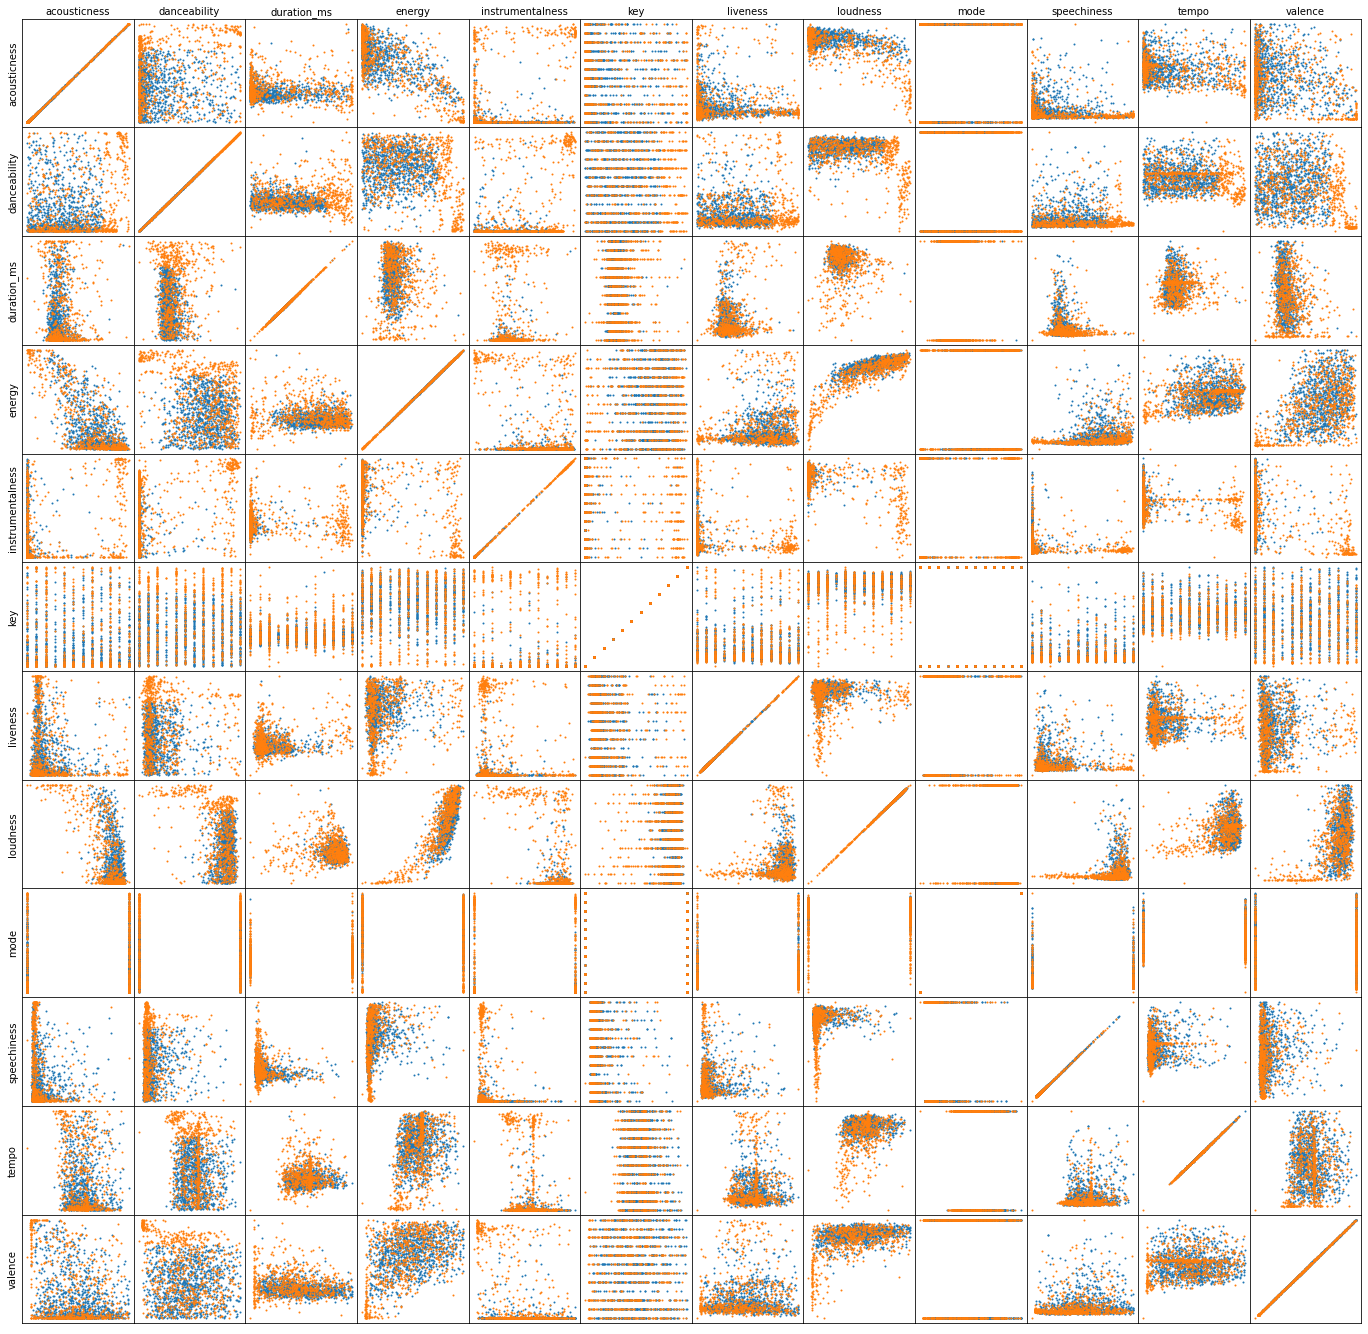

In [11]:
columns = training_df.columns[:-1]

fig, axes = plt.subplots(len(columns), len(columns), figsize=(len(columns) * 2, len(columns) * 2))
for i, col_i in enumerate(columns):
    for j, col_j in enumerate(columns):
        ax = axes[j, i]
        ax.scatter(
            training_df.loc[training_df['rating'] == 1][col_j], 
            training_df.loc[training_df['rating'] == 1][col_i], 
            s=1, c='tab:blue'
        )
        ax.scatter(
            training_df.loc[training_df['rating'] == 0][col_j], 
            training_df.loc[training_df['rating'] == 0][col_i], 
            s=1, c='tab:orange'
        )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(col_j)
        if j == 0:
            ax.set_xlabel(col_i)
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

Number of components for 95% variance: 10


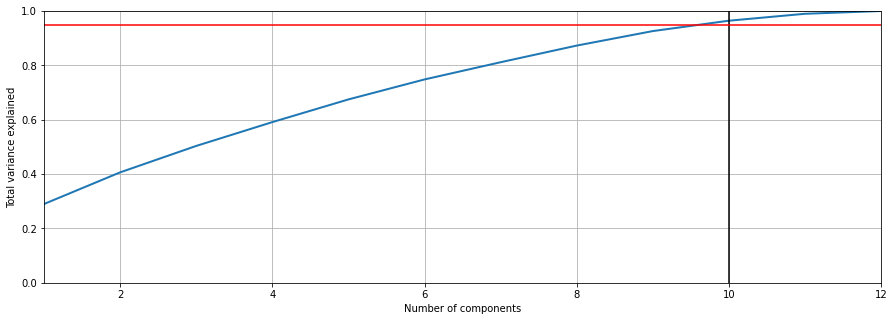

In [13]:
X_train = training_df.drop('rating', axis=1)
y_train = training_df['rating']

X_scaled = StandardScaler().fit_transform(X_train)
pca = decomposition.PCA().fit(X_scaled)

variance_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_ratio)
threshold = 0.95
n_components = next(i for i, v in enumerate(cum_var) if v > threshold) + 1
print(f"Number of components for {threshold*100:.0f}% variance: {n_components}")

plt.figure(figsize=(15,5))
plt.plot(range(1,13), cum_var, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid()
plt.axvline(n_components, c='k')
plt.axhline(threshold, c='r')


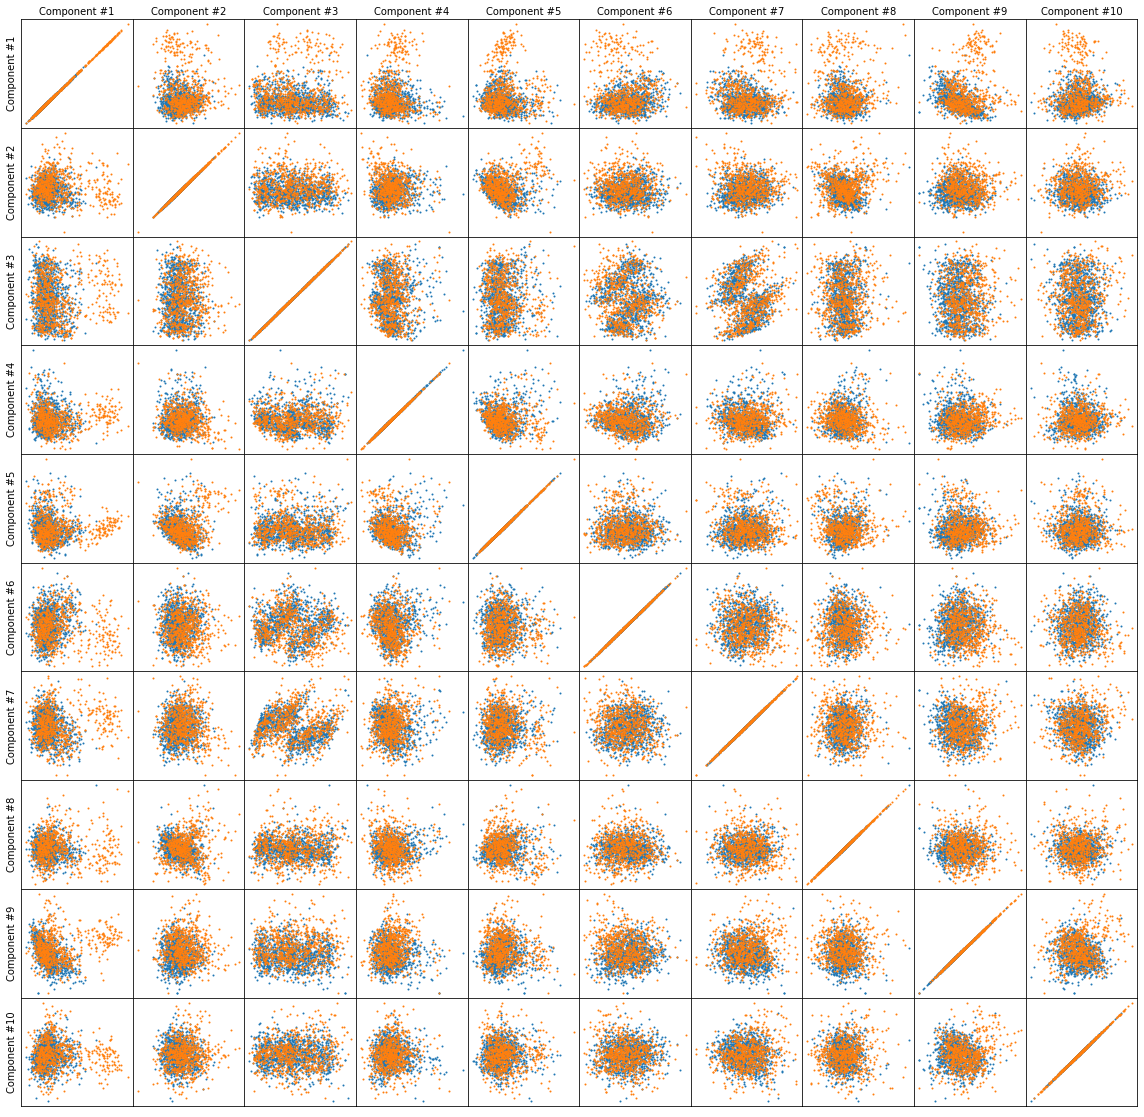

In [14]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(n_components, n_components, figsize=(n_components*2, n_components*2))
for i in range(n_components):
    for j in range(n_components):
        ax = axes[j, i]
        ax.scatter(X_pca[y_train == 1][:, i], X_pca[y_train == 1][:, j], c='tab:blue', s=1)
        ax.scatter(X_pca[y_train == 0][:, i], X_pca[y_train == 0][:, j], c='tab:orange', s=1)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(f"Component #{j + 1}")
        if j == 0:
            ax.set_xlabel(f"Component #{i + 1}")
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

In [15]:
# K-nearest neighbor classification
n_splits = 5
max_neighbors = 50

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

knc_params = {'n_neighbors': range(1, max_neighbors + 1)}
knc = KNeighborsClassifier(n_jobs=-1)

knc_grid = GridSearchCV(knc, knc_params, n_jobs=-1, cv=skf, verbose=1)
knc_grid.fit(X_pca, y_train)

grid_results = pd.DataFrame(knc_grid.cv_results_)
grid_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002918,0.001184,0.117658,0.006386,1,{'n_neighbors': 1},0.635593,0.652542,0.666667,0.666667,0.680791,0.660452,0.015306,49
1,0.003049,0.001733,0.118981,0.003500,2,{'n_neighbors': 2},0.621469,0.604520,0.629944,0.672316,0.635593,0.632768,0.022386,50
2,0.002014,0.000270,0.114190,0.001758,3,{'n_neighbors': 3},0.661017,0.689266,0.663842,0.709040,0.689266,0.682486,0.017919,47
3,0.002013,0.000127,0.116449,0.004578,4,{'n_neighbors': 4},0.629944,0.661017,0.672316,0.692090,0.666667,0.664407,0.020166,48
4,0.002330,0.000721,0.114296,0.002522,5,{'n_neighbors': 5},0.689266,0.709040,0.692090,0.720339,0.714689,0.705085,0.012326,44
5,0.001958,0.000074,0.114851,0.002128,6,{'n_neighbors': 6},0.672316,0.689266,0.686441,0.717514,0.709040,0.694915,0.016277,46
6,0.002018,0.000159,0.117173,0.003511,7,{'n_neighbors': 7},0.692090,0.703390,0.717514,0.717514,0.720339,0.710169,0.010809,28
7,0.001950,0.000091,0.116800,0.003505,8,{'n_neighbors': 8},0.677966,0.700565,0.700565,0.728814,0.700565,0.701695,0.016139,45
8,0.002868,0.000830,0.114937,0.001904,9,{'n_neighbors': 9},0.692090,0.728814,0.711864,0.748588,0.692090,0.714689,0.021808,10
9,0.002809,0.001332,0.114110,0.002293,10,{'n_neighbors': 10},0.689266,0.723164,0.703390,0.754237,0.672316,0.708475,0.028328,39


(0.0, 50.0)

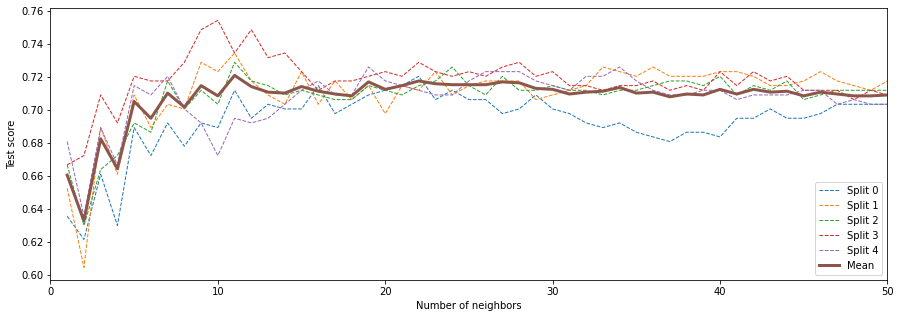

In [16]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results['param_n_neighbors'], grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['param_n_neighbors'], grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Test score')
plt.xlim(0, max_neighbors)

In [18]:
# Random Forest classification

rfc_parameters = {
    'max_features': [4, 6, 8, 10], 
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [3, 5, 7]
}
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
forest_grid = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1)
forest_grid.fit(X_pca, y_train)
grid_results = pd.DataFrame(forest_grid.cv_results_)
grid_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   42.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.395934,0.005581,0.105545,0.003351,3,4,1,"{'max_depth': 3, 'max_feat...",0.711864,0.706215,0.697740,0.720339,0.686441,0.704520,0.011661,40
1,0.390871,0.013789,0.111836,0.011408,3,4,3,"{'max_depth': 3, 'max_feat...",0.720339,0.703390,0.694915,0.717514,0.694915,0.706215,0.010867,36
2,0.394774,0.012011,0.102669,0.000326,3,4,5,"{'max_depth': 3, 'max_feat...",0.714689,0.706215,0.689266,0.720339,0.692090,0.704520,0.012196,38
3,0.393729,0.008570,0.103856,0.001917,3,4,7,"{'max_depth': 3, 'max_feat...",0.723164,0.706215,0.694915,0.717514,0.697740,0.707910,0.010955,34
4,0.525190,0.079567,0.111037,0.007145,3,6,1,"{'max_depth': 3, 'max_feat...",0.731638,0.694915,0.703390,0.717514,0.689266,0.707345,0.015431,35
5,0.418186,0.046864,0.109535,0.007977,3,6,3,"{'max_depth': 3, 'max_feat...",0.725989,0.706215,0.697740,0.720339,0.692090,0.708475,0.012933,33
6,0.432911,0.037014,0.105940,0.001919,3,6,5,"{'max_depth': 3, 'max_feat...",0.714689,0.700565,0.689266,0.725989,0.694915,0.705085,0.013441,37
7,0.413122,0.042028,0.111984,0.015134,3,6,7,"{'max_depth': 3, 'max_feat...",0.711864,0.703390,0.700565,0.717514,0.686441,0.703955,0.010630,41
8,0.655429,0.100909,0.111587,0.011203,3,8,1,"{'max_depth': 3, 'max_feat...",0.725989,0.694915,0.672316,0.723164,0.683616,0.700000,0.021320,47
9,0.600215,0.052965,0.107181,0.006212,3,8,3,"{'max_depth': 3, 'max_feat...",0.734463,0.700565,0.677966,0.728814,0.677966,0.703955,0.024129,44


([], [])

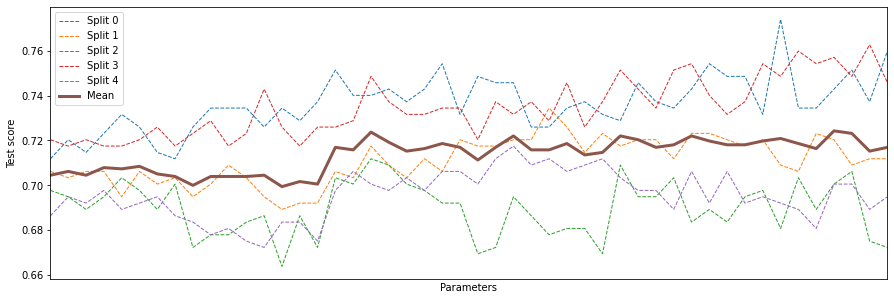

In [27]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

In [37]:
# Decision tree classification

tree_parameters = {
    'max_depth': range(1,11),
    'max_features': range(4, 11)
}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_parameters, cv=skf, n_jobs=-1, verbose=True)
tree_grid.fit(X_pca, y_train)
grid_results = pd.DataFrame(tree_grid.cv_results_)
print("Best score: ", tree_grid.best_score_)
grid_results

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    0.5s


Best score:  0.7045197740112995


[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.9s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001727,0.000137,0.000640,0.000065,1,4,"{'max_depth': 1, 'max_feat...",0.644068,0.635593,0.629944,0.601695,0.629944,0.628249,0.014248,69
1,0.003298,0.002956,0.000608,0.000069,1,5,"{'max_depth': 1, 'max_feat...",0.618644,0.618644,0.629944,0.649718,0.629944,0.629379,0.011356,68
2,0.003809,0.004224,0.000582,0.000065,1,6,"{'max_depth': 1, 'max_feat...",0.593220,0.618644,0.658192,0.629944,0.629944,0.625989,0.020957,70
3,0.003208,0.002439,0.000547,0.000037,1,7,"{'max_depth': 1, 'max_feat...",0.618644,0.627119,0.629944,0.649718,0.629944,0.631073,0.010201,67
4,0.001980,0.000108,0.000589,0.000045,1,8,"{'max_depth': 1, 'max_feat...",0.618644,0.627119,0.658192,0.629944,0.638418,0.634463,0.013441,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.008473,0.001285,0.000639,0.000037,10,6,"{'max_depth': 10, 'max_fea...",0.666667,0.655367,0.677966,0.672316,0.680791,0.670621,0.009040,52
66,0.008152,0.000341,0.000659,0.000081,10,7,"{'max_depth': 10, 'max_fea...",0.644068,0.677966,0.694915,0.677966,0.677966,0.674576,0.016607,44
67,0.009676,0.000829,0.000601,0.000027,10,8,"{'max_depth': 10, 'max_fea...",0.672316,0.689266,0.658192,0.680791,0.694915,0.679096,0.012957,35
68,0.011417,0.001434,0.000700,0.000129,10,9,"{'max_depth': 10, 'max_fea...",0.618644,0.706215,0.686441,0.666667,0.717514,0.679096,0.034855,35


([], [])

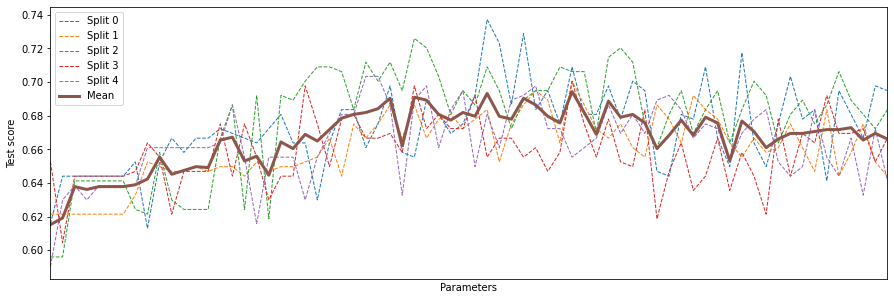

In [35]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

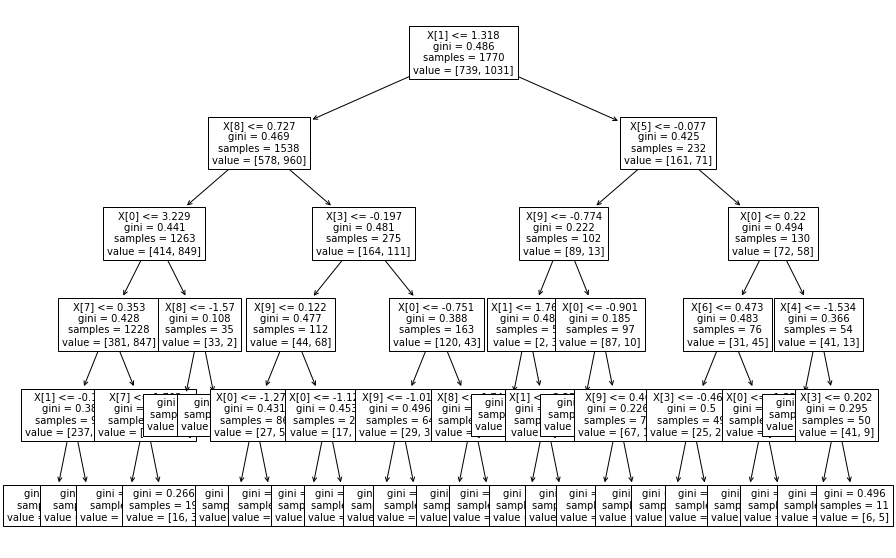

In [52]:
plt.figure(figsize=(15, 10))
plot_tree(tree_grid.best_estimator_, fontsize=10)
print()